# A Multigroup 1D Detector

In this example we will explore using OpenSn's linear Boltzmann solver for computing detector response functions in a desired region of interest (RoI). 

The following is a complete transport simulation example. Each element of the simulation can be described in the sections below:
- [Prerequisites](#prerequisites)
- [Geometry](#geometry)
- [Mesh](#mesh)
    - [Material IDs](#material-ids)
    - [Cross Sections](#cross-sections)
- [Solver](#Solver)
    - [Angular Quadrature](#angular-quadrature)
    - [Group Structure](#group-structure)
    - [Source Definition](#source-definition)
    - [Discrete Ordinates Problem](#discrete-ordinates-problem)
    - [Execute](#execute)
- [Post Processing](#post-processing)
    - [Volumetric Field Function](#volumetric-field-function)
    - [Linear Field Function](#linear-field-function)
    - [Compute Leakage](#compute-leakage)
    - [Compute Balance](#compute-balance)

---

## **Prerequisites**

Before running this example, make sure that the **Python module of OpenSn** was installed.

### Converting and Running this Notebook from the Terminal
To run this notebook from the terminal, simply type:

`jupyter nbconvert --to python --execute detector.ipynb`.

To run this notebook in parallel (for example, using 4 processes), simply type:

`mpiexec -n 4 jupyter nbconvert --to python --execute detector.ipynb`.

In [1]:
from mpi4py import MPI
size = MPI.COMM_WORLD.size
rank = MPI.COMM_WORLD.rank
barrier = MPI.COMM_WORLD.barrier

if rank == 0:
    print(f"Running the LBS detector example with {size} MPI processors.")

Running the LBS detector example with 1 MPI processors.


### Import Requirements

Import required classes and functions from the Python interface of OpenSn. Make sure that the path
to PyOpenSn is appended to Python's PATH.

In [2]:
import os
import sys
import math
import numpy as np

# assuming that the execute dir is the notebook dir
# this line is not necessary when PyOpenSn is installed using pip
sys.path.append("../../..")

from pyopensn.mesh import OrthogonalMeshGenerator
from pyopensn.xs import MultiGroupXS
from pyopensn.source import PointSource, VolumetricSource
from pyopensn.aquad import GLProductQuadrature1DSlab
from pyopensn.solver import DiscreteOrdinatesProblem, SteadyStateSourceSolver
from pyopensn.math import Vector3
from pyopensn.fieldfunc import FieldFunctionInterpolationVolume, \
                               FieldFunctionInterpolationLine, \
                               FieldFunctionGridBased
from pyopensn.logvol import RPPLogicalVolume
from pyopensn.context import UseColor, Finalize

OpenSn version 0.0.1
2025-09-20 01:41:44 Running OpenSn with 1 processes.



---

## **Geometry**
In this example, we define a 1D multi-group, source-driven detector response problem using the WIMS69 energy group structure. The neutron source is modeled as a 0.4 cm slab of Cf-252 encased in 0.1 cm slabs of stainless steel (SS-316). The detector is modeled as a 2.4 cm region of He-3 enclosed in a 0.07 cm SS-316 sleeve and surrounded by high-density polyethylene (HDPE). The geometric layout of the problem is shown below:

<img src="images/detector_geom.png"/>

---


## **Mesh**
### Orthogonal Mesh Generation
To generate the mesh for this problem, we use the in-house orthogonal mesh generator to create a simple Cartesian grid. We begin by creating a list of nodes along the spatial z-direction for  each region. 

In [3]:
# Source Interfaces
src = [2.7, 2.8, 3.2, 3.3]
d_src = [2, 4, 2]

# Detector Interfaces
det = [13.0, 16.73, 16.8, 19.2, 19.27, 23.0]
d_det = [6, 2, 4, 2, 6]

z  = [0.0, *src, *det, 25.0]
dz = [4, *d_src, 10, *d_det, 4]

ref = 10
nodesz = np.concatenate([np.linspace(z[i], z[i+1], dz[i]*ref+1)[1:] if i>0 else np.linspace(z[i], z[i+1], dz[i]*ref+1) 
                         for i in range(len(z)-1)]).tolist()

meshgen = OrthogonalMeshGenerator(node_sets=[nodesz])
grid = meshgen.Execute()

[0]  Done checking cell-center-to-face orientations
[0]  00:00:00.1 Establishing cell connectivity.
[0]  00:00:00.1 Vertex cell subscriptions complete.
[0]  00:00:00.1 Surpassing cell 46 of 460 (10%)
[0]  00:00:00.1 Surpassing cell 92 of 460 (20%)
[0]  00:00:00.1 Surpassing cell 139 of 460 (30%)
[0]  00:00:00.1 Surpassing cell 184 of 460 (40%)
[0]  00:00:00.1 Surpassing cell 230 of 460 (50%)
[0]  00:00:00.1 Surpassing cell 277 of 460 (60%)
[0]  00:00:00.1 Surpassing cell 323 of 460 (70%)
[0]  00:00:00.1 Surpassing cell 368 of 460 (80%)
[0]  00:00:00.1 Surpassing cell 414 of 460 (90%)
[0]  00:00:00.1 Surpassing cell 460 of 460 (100%)
[0]  00:00:00.1 Establishing cell boundary connectivity.
[0]  00:00:00.1 Done establishing cell connectivity.
[0]  Number of cells per partition (max,min,avg) = 460,460,460
[0]  
[0]  Mesh statistics:
[0]    Global cell count             : 460
[0]    Local cell count (avg,max,min): 460,460,460
[0]    Ghost-to-local ratio (avg)    : 0
[0]  


### Material IDs
When using the in-house `OrthogonalMeshGenerator`, no material IDs are assigned. The user needs to assign material IDs to all cells. We will begin by assigning the background material ID with a value of 0.

In [4]:
grid.SetUniformBlockID(0)

[0]  00:00:00.1 Done setting block id 0 to all cells


Next we will assign material IDs for the detector and source. When assigning material IDs via logical volumes the IDs for each cell is overriden by the most recent assignment. That is to say, assigning a material ID of 1 to any region in our domain will override the previously set ID to those cells. 

In [5]:
# Detector Volume
det_hdpe = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=det[0], zmax=det[-1],
)
grid.SetBlockIDFromLogicalVolume(det_hdpe, 1, True)

det_sleeve = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=det[1], zmax=det[-2],
)
grid.SetBlockIDFromLogicalVolume(det_sleeve, 2, True)

det_he3 = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=det[2], zmax=det[-3],
)
grid.SetBlockIDFromLogicalVolume(det_he3, 3, True)

In [6]:
# Src Volume
src_casing = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=src[0], zmax=src[-1],
)
grid.SetBlockIDFromLogicalVolume(src_casing, 2, True)

src_cf = RPPLogicalVolume(
            infx=True,
            infy=True,
            zmin=src[1], zmax=src[-2],
)
grid.SetBlockIDFromLogicalVolume(src_cf, 4, True)


### Cross Sections
In this problem, we compute the multigroup absorption reaction rate in a He-3 detector. We begin by importing the multigroup cross sections, using the WIMS69 energy group structure for five materials:
- Air
- HDPE
- SS-316
- He-3
- Cf-252

In [7]:
xs_dir = "WIMS69"
xs_air = MultiGroupXS()
xs_air.LoadFromOpenSn(xs_dir+"/Air.cxs")

xs_hdpe = MultiGroupXS()
xs_hdpe.LoadFromOpenSn(xs_dir+"/HDPE.cxs")

xs_steel = MultiGroupXS()
xs_steel.LoadFromOpenSn(xs_dir+"/SS_316.cxs")

xs_he3 = MultiGroupXS()
xs_he3.LoadFromOpenSn(xs_dir+"/He3.cxs")

xs_cf = MultiGroupXS()
xs_cf.LoadFromOpenSn(xs_dir+"/Cf252.cxs")

xsecs = [{"block_ids": [0], "xs": xs_air},
         {"block_ids": [1], "xs": xs_hdpe},
         {"block_ids": [2], "xs": xs_steel},
         {"block_ids": [3], "xs": xs_he3},
         {"block_ids": [4], "xs": xs_cf}]

[0]  Reading OpenSn cross-section file "WIMS69/Air.cxs"
[0]  Reading OpenSn cross-section file "WIMS69/HDPE.cxs"
[0]  Reading OpenSn cross-section file "WIMS69/SS_316.cxs"
[0]  Reading OpenSn cross-section file "WIMS69/He3.cxs"
[0]  Reading OpenSn cross-section file "WIMS69/Cf252.cxs"


---

## **Solver**

### Angular Quadrature
Since we are solving a 1D problem we will create Gauss-Legendre Product Quadrature for a 1D slab. In this case we will use 512 polar angles creating a 1D angular quadrature in $\mu$ with a scattering order of 0.

In [8]:
pquad = GLProductQuadrature1DSlab(n_polar=512, 
                                  scattering_order=0)

[0]  Using 1D Slab Gauss–Legendre product quadrature with 512 angles and weight sum of 1.00


### Group Structure
Since we are using the WIMS69 group structure, we define a groupset block with 69 energy groups.

In [9]:
num_groups = 69
grpsets = [
    {
        "groups_from_to": (0, num_groups-1),
        "angular_quadrature": pquad,
        "inner_linear_method": "petsc_gmres",
        "l_abs_tol": 1.0e-9,
        "l_max_its": 500,
        "gmres_restart_interval": 100,
    },
]

### Source Definition
For the volumetric source, we first specify the source spectrum. In this case, we assign a uniform energy spectrum distributed throughout the source logical volume. Using `VolumetricSource`, this group-wise source definition is applied per unit length to material ID 4. Once the `VolumetricSource`is defined, it is added to the physics options.

In [10]:
groups = np.flip([1.00000E-11, 5.00000E-09, 1.00000E-08, 1.50000E-08, 2.00000E-08, 
                  2.50000E-08, 3.00000E-08, 3.50000E-08, 4.20000E-08, 5.00000E-08, 
                  5.80000E-08, 6.70000E-08, 8.00000E-08, 1.00000E-07, 1.40000E-07, 
                  1.80000E-07, 2.20000E-07, 2.50000E-07, 2.80000E-07, 3.00000E-07, 
                  3.20000E-07, 3.50000E-07, 4.00000E-07, 5.00000E-07, 6.25000E-07, 
                  7.80000E-07, 8.50000E-07, 9.10000E-07, 9.50000E-07, 9.72000E-07, 
                  9.96000E-07, 1.02000E-06, 1.04500E-06, 1.07100E-06, 1.09700E-06, 
                  1.12300E-06, 1.15000E-06, 1.30000E-06, 1.50000E-06, 2.10000E-06, 
                  2.60000E-06, 3.30000E-06, 4.00000E-06, 9.87700E-06, 1.59680E-05, 
                  2.77000E-05, 4.80520E-05, 7.55014E-05, 1.48729E-04, 3.67263E-04, 
                  9.06899E-04, 1.42510E-03, 2.23945E-03, 3.51910E-03, 5.53000E-03, 
                  9.11800E-03, 1.50300E-02, 2.47800E-02, 4.08500E-02, 6.73400E-02, 
                  1.11000E-01, 1.83000E-01, 3.02500E-01, 5.00000E-01, 8.21000E-01, 
                  1.35300E+00, 2.23100E+00, 3.67900E+00, 6.06550E+00, 1.00000E+01])
group_width = -np.diff(groups)
dE = groups[0] - groups[-1]
dL = src[-2] - src[1]
Q = (group_width / dE / dL).tolist()

vol_src = VolumetricSource(block_ids=[4], group_strength=Q)

### Discrete Ordinates Problem
For establishing the discrete ordinate problem, we provide;
+ mesh : The mesh
+ num_groups : The number of energy groups
+ groupsets : The groupsets block
+ xs_map : Cross section map
+ volumetric_sources : The volumetric source
+ boundary_conditions : The boundary conditions
+ options : Physics solver options

In [11]:
phys = DiscreteOrdinatesProblem(
    mesh=grid,
    num_groups=num_groups,
    groupsets=grpsets,
    xs_map=xsecs,
    volumetric_sources = [vol_src],
    boundary_conditions = [
        {"name": "zmin", "type": "vacuum"},
        {"name": "zmax", "type": "vacuum"}
    ],
    options = {"save_angular_flux": True},
)

### Execute
We then create the physics solver, initialize it, and execute it.

In [12]:
ss_solver = SteadyStateSourceSolver(problem=phys)
ss_solver.Initialize()
ss_solver.Execute()

[0]  
[0]  Initializing LBS SteadyStateSourceSolver with name: LBSDiscreteOrdinatesProblem
[0]  
[0]  Scattering order    : 0
[0]  Number of Groups    : 69
[0]  Number of Group sets: 1
[0]  
[0]  ***** Groupset 0 *****
[0]  Groups:
[0]      0     1     2     3     4     5     6     7     8     9    10    11 
[0]     12    13    14    15    16    17    18    19    20    21    22    23 
[0]     24    25    26    27    28    29    30    31    32    33    34    35 
[0]     36    37    38    39    40    41    42    43    44    45    46    47 
[0]     48    49    50    51    52    53    54    55    56    57    58    59 
[0]     60    61    62    63    64    65    66    67    68 
[0]  
[0]  Initializing spatial discretization.
[0]  Computing unit integrals.
[0]  Ghost cell unit cell-matrix ratio: 0%
[0]  Cell matrices computed.
[0]  *** WARNING ***  Computing the flux with fewer scattering moments than are present in the cross-section data for block 0
[0]  *** WARNING ***  Computing the flux 

---

## Post Processing
### Volumetric Field Function

With the solver executed, we now create a `FieldFunction`. In OpenSn we define a `FieldFunction` for the response we will like to calculate. In this case we are looking to compute the total $He^3$ absorption reaction rate in our detector: 

$$
\text{QoI} = \sum^G_g \, \text{RR}^g = \sum^G_g \, \int_\mathcal{D} d^3r \, \int_{(4\pi)} d\Omega \, \sigma^g_{det}(\vec{r}) \psi^g(\vec{r},\vec\Omega)  = \sum^G_g \, \int_\mathcal{D} d^3r \, \sigma^g_{det}(\vec{r}) \phi^g(\vec{r}) 
$$

Thus, in OpenSn we will generate a scalar field function using `GetScalarFluxFieldFunction` with a `sum` over the RoI. At each group the solution $\phi^g(\vec{r})$ is multiplied by the detector response at that group $\sigma^{He3,g}_{a}$. 

In [13]:
fflist = phys.GetScalarFluxFieldFunction(only_scalar_flux=False)

fields = []
flux = []
for g in range(num_groups):
    ffvol = FieldFunctionInterpolationVolume()
    ffvol.SetOperationType("sum")  # OP_SUM operation
    ffvol.SetLogicalVolume(det_he3)
    ffvol.AddFieldFunction(fflist[g][0])
    ffvol.Initialize()
    ffvol.Execute()
    phi_g = ffvol.GetValue()
    flux.append(phi_g)

    fields.append(fflist[g][0])

sig_a = np.array(xs_he3.sigma_a)
resp = sig_a * flux

Forward Total Flux : 2.896951e+00
Forward Total Response : 1.237160e-01


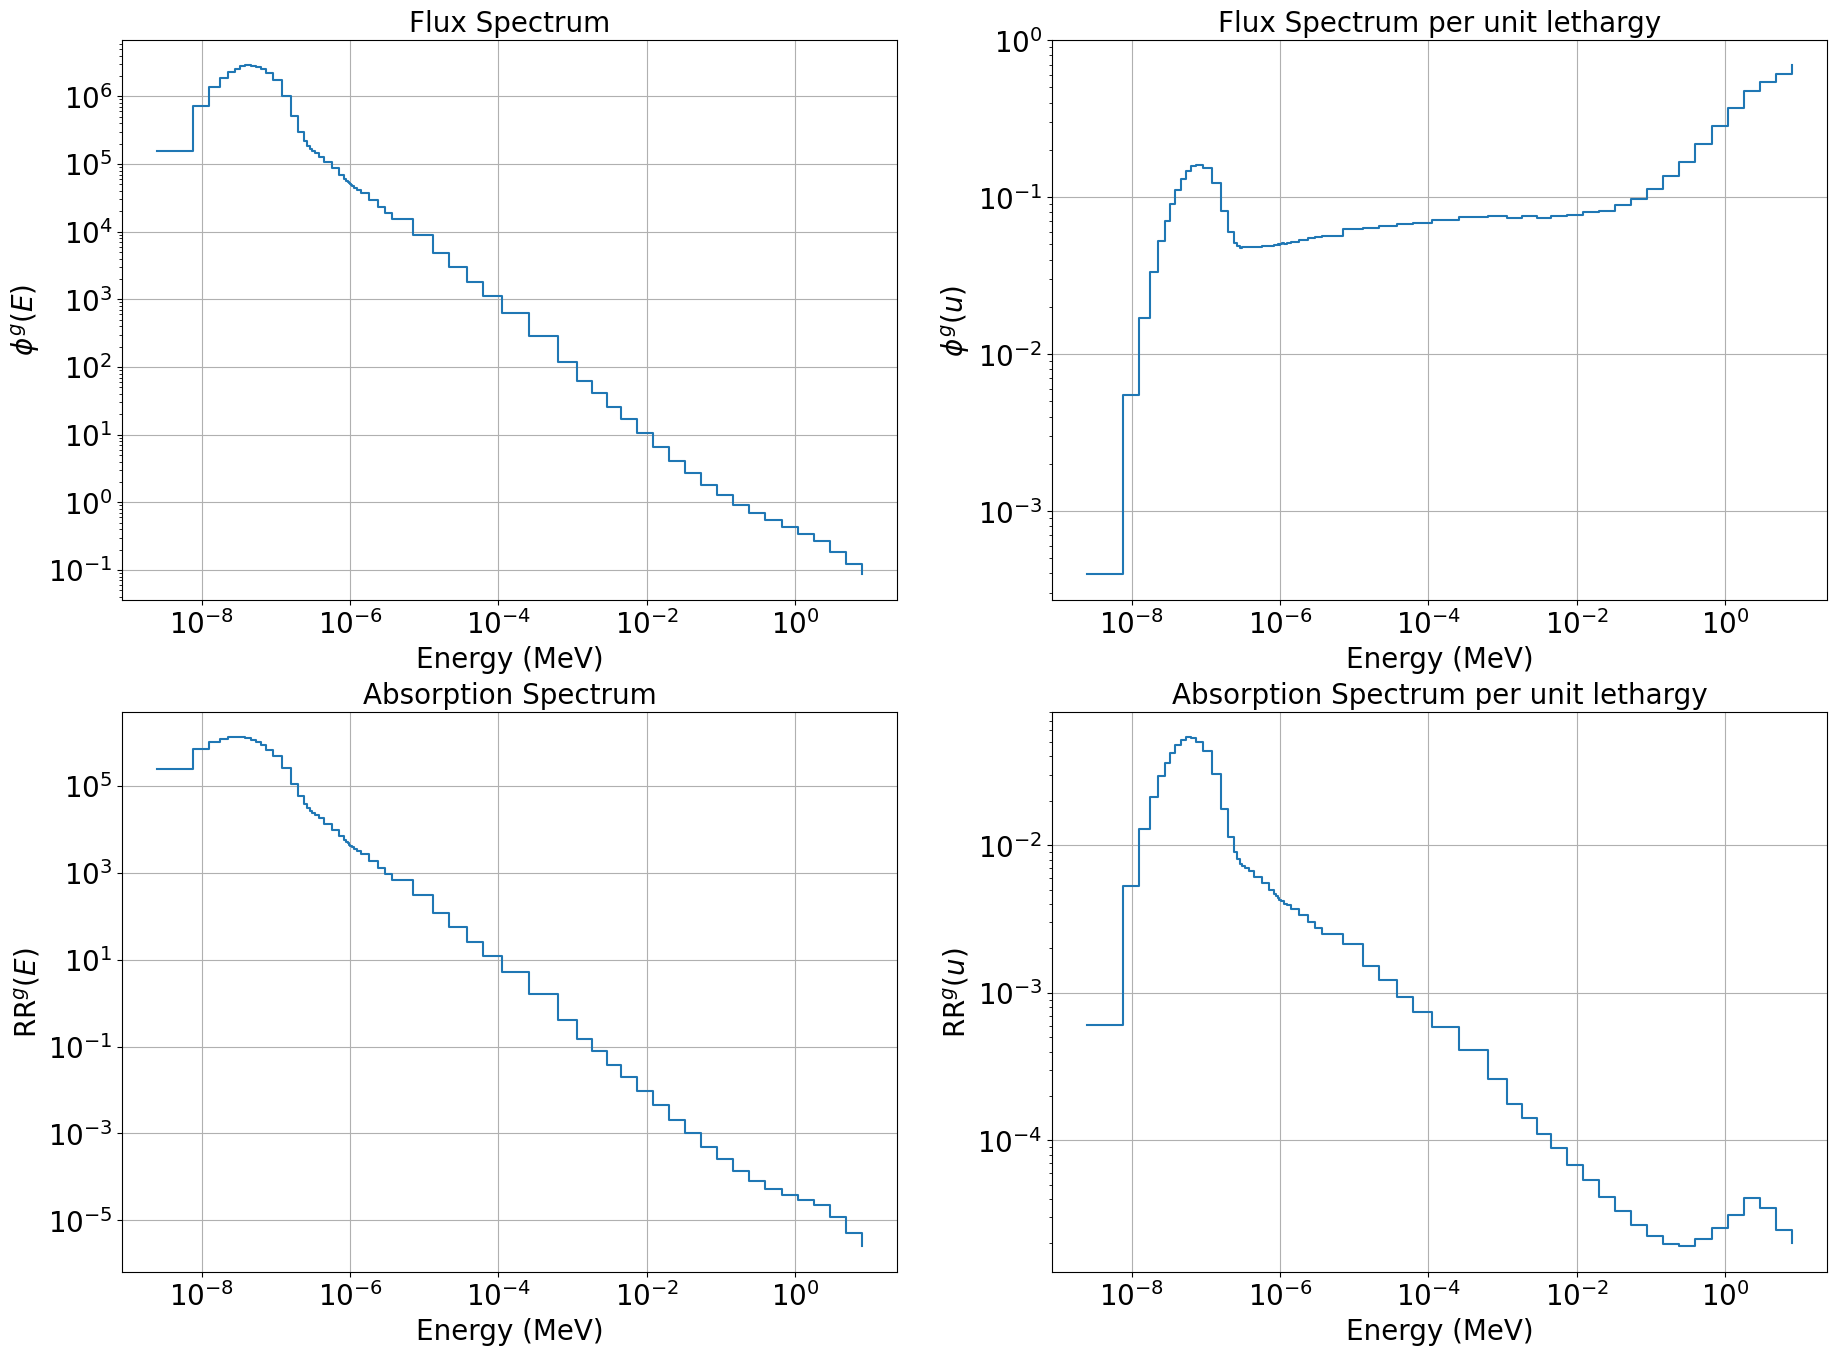

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(22,16))
axs = []
if rank == 0:
    emid = (groups[:-1]+groups[1:])/2

    # Flux spectrum
    flux_spec = flux / group_width

    axs.append(fig.add_subplot(221))
    axs[0].loglog(emid, flux_spec, drawstyle='steps')
    axs[0].set_xlabel("Energy (MeV)", fontsize=20)
    axs[0].set_ylabel(r"$\phi^g(E)$", fontsize=20)
    axs[0].set_title("Flux Spectrum", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].grid()

    # Flux spectrum per unit lethargy
    flux_leth = flux_spec * emid

    axs.append(fig.add_subplot(222))
    axs[1].loglog(emid, flux_leth, drawstyle='steps')
    axs[1].set_xlabel("Energy (MeV)", fontsize=20)
    axs[1].set_ylabel(r"$\phi^g(u)$", fontsize=20)
    axs[1].set_title("Flux Spectrum per unit lethargy", fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
    axs[1].grid()


    # Absorption spectrum
    resp_spec = resp / group_width

    axs.append(fig.add_subplot(223))
    axs[2].loglog(emid, resp_spec,  drawstyle='steps')
    axs[2].set_xlabel("Energy (MeV)", fontsize=20)
    axs[2].set_ylabel(r"$\text{RR}^g(E)$", fontsize=20)
    axs[2].set_title("Absorption Spectrum", fontsize=20)
    axs[2].tick_params(axis='both', which='major', labelsize=20)
    axs[2].grid()

    # Absorption spectrum per unit lethargy
    resp_leth = resp_spec * emid

    axs.append(fig.add_subplot(224))
    axs[3].loglog(emid, resp_leth, drawstyle='steps')
    axs[3].set_xlabel("Energy (MeV)", fontsize=20)
    axs[3].set_ylabel(r"$\text{RR}^g(u)$", fontsize=20)
    axs[3].set_title("Absorption Spectrum per unit lethargy", fontsize=20)
    axs[3].tick_params(axis='both', which='major', labelsize=20)
    axs[3].grid()

    print(f"{'Forward Total Flux :'} {np.sum(flux):.6e}")
    print(f"{'Forward Total Response :'} {np.sum(resp):.6e}")

With our field function defined, we can also export the multi-group scalar flux, $\phi^g$, to a .vtu file using ``ExportMultipleToPVTU``.

In [15]:
FFGrid = FieldFunctionGridBased
FFGrid.ExportMultipleToPVTU(fields, "Flux/detector")

[0]  Exporting field functions to PVTU with file base "Flux/detector"
[0]  Done exporting field functions to PVTU.


### Linear Field Function
To plot the scalar flux along a line segment of the problem we use ``FieldFunctionInterpolationLine()``

[0]  Exported CSV file for field func "phi_g000_m00" to "Flux/detector_phi_g000_m00.csv"
[0]  Exported CSV file for field func "phi_g001_m00" to "Flux/detector_phi_g001_m00.csv"
[0]  Exported CSV file for field func "phi_g002_m00" to "Flux/detector_phi_g002_m00.csv"
[0]  Exported CSV file for field func "phi_g003_m00" to "Flux/detector_phi_g003_m00.csv"
[0]  Exported CSV file for field func "phi_g004_m00" to "Flux/detector_phi_g004_m00.csv"
[0]  Exported CSV file for field func "phi_g005_m00" to "Flux/detector_phi_g005_m00.csv"
[0]  Exported CSV file for field func "phi_g006_m00" to "Flux/detector_phi_g006_m00.csv"
[0]  Exported CSV file for field func "phi_g007_m00" to "Flux/detector_phi_g007_m00.csv"
[0]  Exported CSV file for field func "phi_g008_m00" to "Flux/detector_phi_g008_m00.csv"
[0]  Exported CSV file for field func "phi_g009_m00" to "Flux/detector_phi_g009_m00.csv"
[0]  Exported CSV file for field func "phi_g010_m00" to "Flux/detector_phi_g010_m00.csv"
[0]  Exported CSV fil

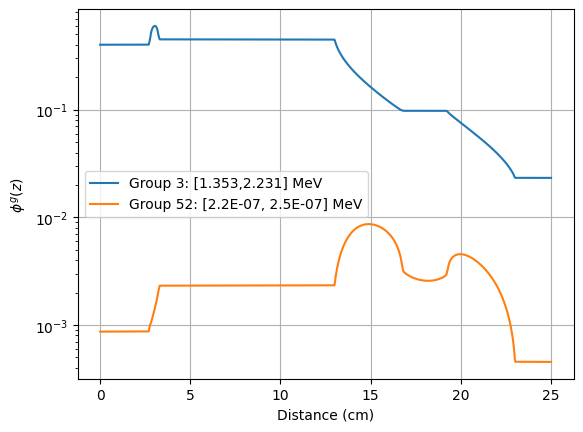

In [16]:
import csv
from os import walk

for g in range(num_groups):
    # Linear Field Function
    ffline = FieldFunctionInterpolationLine()
    ffline.SetInitialPoint(Vector3(0.0, 0.0, z[0]))
    ffline.SetFinalPoint(Vector3(0.0, 0.0, z[-1]))
    ffline.SetNumberOfPoints(1000)
    ffline.AddFieldFunction(fflist[g][0])
    ffline.Initialize()
    ffline.Execute()
    ffline.ExportToCSV("Flux/detector")

# Convert each CSV to a python dictionary
def CSVToDict(filename):
    data = {}
    with open(filename, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            for key, value in row.items():
                data.setdefault(key, []).append(float(value))
    return data

# Collect each groupwise flux distribution into a dictionary
# Flux -> g001 -> {x,y,z,phi_g001_m00}
#      -> g002 -> {x,y,z,phi_g002_m00}
#      -> .... ->         ...
#      -> g068 -> {x,y,z,phi_g068_m00}        
Flux = {}
for (dirpath, dirnames, filenames) in walk('Flux/'):
   for filename in filenames:
        if filename.split(".")[1] == "csv":
            grp = filename.split('.')[0].split('_')[2]
            key = "_".join(filename.split('.')[0].split('_')[1:])
            fwd_dict = CSVToDict("Flux/"+filename)
            Flux[grp] = CSVToDict("Flux/"+filename)

if rank == 0:
    # Plot of the flux distribution
    z = Flux['g003']['z']
    flux_g3 = Flux['g003']['phi_g003_m00']
    flux_g52 = Flux['g052']['phi_g052_m00']
    
    plt.figure()
    plt.semilogy(z, flux_g3, label="Group 3: [1.353,2.231] MeV")
    plt.semilogy(z, flux_g52, label="Group 52: [2.2E-07, 2.5E-07] MeV")
    plt.xlabel("Distance (cm)")
    plt.ylabel(r"$\phi^g(z)$")
    plt.legend()
    plt.grid()
    plt.show()


### Compute Leakage
We can simultaneously compute the groupwise leakage rate at the left ($Z_\text{min}$) and/or right ($Z_\text{max}$) boundaries of the problem domain, $\vec{j}^g\big|_{\Gamma\pm}$.

Total Leakage ZMin : 1.168125e+00
Total Leakage ZMax : 1.637177e-01
Total Leakage : 1.331843e+00


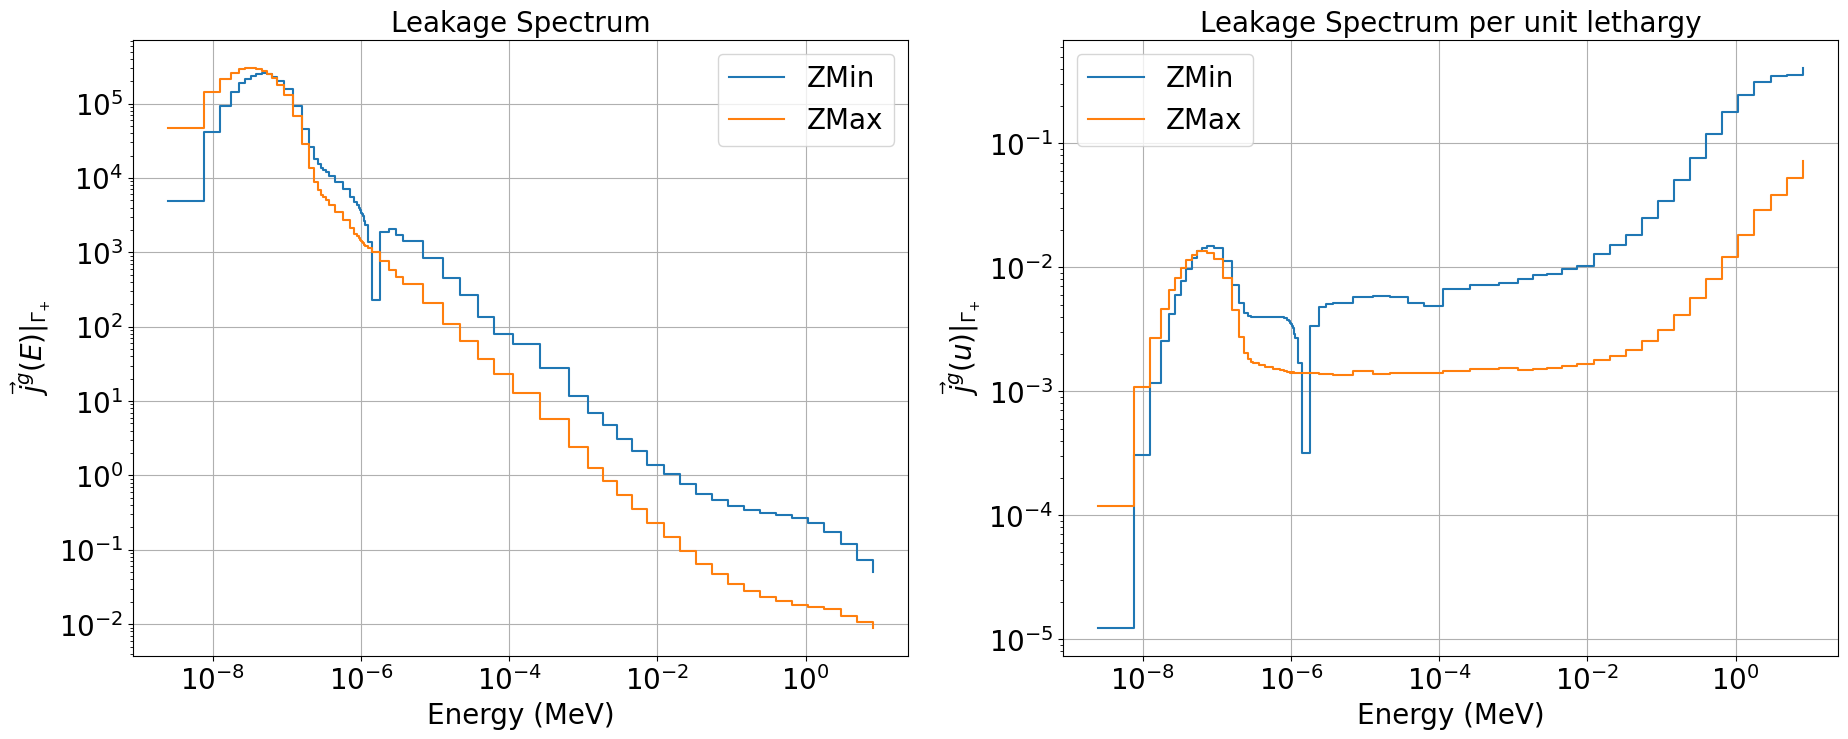

In [17]:
leakage = phys.ComputeLeakage(["zmin", "zmax"]) 
lkg_zmin = leakage['zmin']
lkg_zmax = leakage['zmax']

fig = plt.figure(figsize=(22,8))
axs = []
if rank == 0:
    # Leakage spectrum
    axs.append(fig.add_subplot(121))
    axs[0].loglog(emid, lkg_zmin/group_width, drawstyle='steps', label="ZMin")
    axs[0].loglog(emid, lkg_zmax/group_width, drawstyle='steps', label="ZMax")
    axs[0].set_xlabel("Energy (MeV)", fontsize=20)
    axs[0].set_ylabel(r"$\vec{j}^{g}(E)|_{\Gamma_{\text{+}}}$", fontsize=20)
    axs[0].set_title("Leakage Spectrum", fontsize=20)
    axs[0].tick_params(axis='both', which='major', labelsize=20)
    axs[0].legend(fontsize=20)
    axs[0].grid()

    # Leakage spectrum per unit lethargy
    axs.append(fig.add_subplot(122))
    axs[1].loglog(emid, lkg_zmin*emid/group_width, drawstyle='steps', label="ZMin")
    axs[1].loglog(emid, lkg_zmax*emid/group_width, drawstyle='steps', label="ZMax")
    axs[1].set_xlabel("Energy (MeV)", fontsize=20)
    axs[1].set_ylabel(r"$\vec{j}^{g}(u)|_{\Gamma_{\text{+}}}$", fontsize=20)
    axs[1].set_title("Leakage Spectrum per unit lethargy", fontsize=20)
    axs[1].tick_params(axis='both', which='major', labelsize=20)
    axs[1].legend(fontsize=20)
    axs[1].grid()
    
    print(f"{'Total Leakage ZMin :'} {np.sum(lkg_zmin):.6e}")
    print(f"{'Total Leakage ZMax :'} {np.sum(lkg_zmax):.6e}")
    print(f"{'Total Leakage :'} {np.sum(lkg_zmin)+np.sum(lkg_zmax):.6e}")


### Compute Balance

In [18]:
ss_solver = SteadyStateSourceSolver(problem=phys, compute_balance=True)

[0]  Balance table:
[0]   Absorption rate             = 4.266710e-01
[0]   Production rate             = 1.755504e+00
[0]   In-flow rate                = 0.000000e+00
[0]   Out-flow rate               = 1.331843e+00
[0]   Gain (In-flow + Production) = 1.755504e+00
[0]   Balance (Gain - Loss)       = -3.010000e-03
[0]   Balance/Gain, in %          = -1.714607e-01


---

## Finalize (for Jupyter Notebook only)

In Python script mode, PyOpenSn automatically handles environment termination. However, this
automatic finalization does not occur when running in a Jupyter notebook, so explicit finalization
of the environment at the end of the notebook is required. Do not call the finalization in Python
script mode, or in console mode.

Note that PyOpenSn's finalization must be called before MPI's finalization.


In [19]:
from IPython import get_ipython

def finalize_env():
    Finalize()
    MPI.Finalize()

ipython_instance = get_ipython()
if ipython_instance is not None:
    ipython_instance.events.register("post_execute", finalize_env)

os.system("rm -rf Data Flux Results")

0


Elapsed execution time: 00:00:53.2
2025-09-20 01:42:38 OpenSn finished execution.
